In [51]:
from skimage.io import imread
from skimage.filters import median
from skimage.morphology import disk
from sklearn.mixture import GaussianMixture

import cv2

import numpy as np
import matplotlib.pyplot as plt
import maxflow

from pyevtk.hl import gridToVTK
import os 

In [2]:
imgs = imread('../data/nerves_part.tiff')
imgs = imgs.astype(float) / 255

In [3]:
I_orig = imgs[500]

In [4]:
plt.rcParams['figure.figsize'] = [15, 10]

### Thresholding

In [5]:
I = median(I_orig, disk(5))  # elipse
f = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
I = cv2.filter2D(I, -1, f)   # sharpener

In [6]:
S = np.where(I > 0.4, 1, 0)

Text(0.5, 1.0, 'Segmented image')

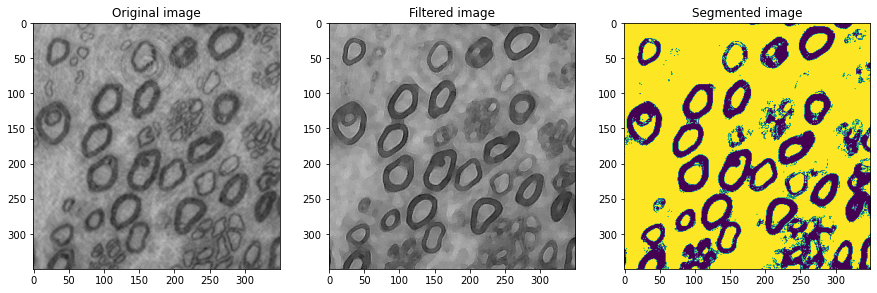

In [7]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(I_orig, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(I, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[1].set_title('Filtered image')
ax[2].imshow(S)
ax[2].set_title('Segmented image')

### MRF

In [8]:
def mrf(I, mu, beta):
    g = maxflow.Graph[float]()
    nodeids = g.add_grid_nodes(I.shape)
    g.add_grid_edges(nodeids, beta)
    g.add_grid_tedges(nodeids, (I-mu[1])**2, (I-mu[0])**2)

    g.maxflow()
    return g.get_grid_segments(nodeids)


def estimate_mu(img):
    img = img.ravel()
    gm = GaussianMixture(n_components=2, random_state=0)
    gm.fit(img[:, np.newaxis])
    return list(gm.means_.T[0])


def process_img(img):
    I = median(img, disk(5))  # disk = elipse
    f = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    I = cv2.filter2D(I, -1, f)   # sharpener
    return I

In [9]:
img = imgs[200]

I = process_img(img)
mu = estimate_mu(I)
I_seg = mrf(I, mu, beta=0.01)

Text(0.5, 1.0, 'Segmented image')

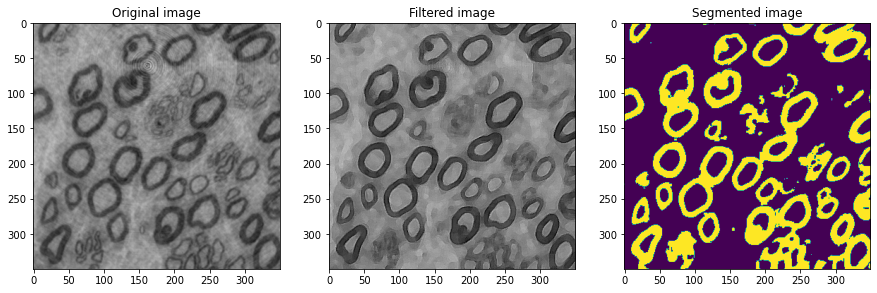

In [10]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(img, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(I, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[1].set_title('Filtered image')
ax[2].imshow(I_seg)
ax[2].set_title('Segmented image')

In [44]:
from skimage.morphology import binary_closing, binary_erosion, remove_small_objects, disk

In [46]:

Imgs_seg_list = []
try:
    for img in imgs:
        I = process_img(img)
        mu = estimate_mu(I)
        I_seg = mrf(I, mu, beta=0.01)
        I_seg = binary_closing(I_seg, disk(1))
        I_seg = remove_small_objects(I_seg, min_size=150)
        cv2.imshow('image', I_seg.astype(np.float32))
        cv2.waitKey(20)
        Imgs_seg_list.append(I_seg)
except KeyboardInterrupt:
    cv2.destroyAllWindows()

### Save data for visualization

In [13]:
def save_to_vtk(data, filepath):
    """
    save the 3d data to a .vtk file. 
    
    Parameters
    ------------
    data : 3d np.array
        3d matrix that we want to visualize
    filepath : str
        where to save the vtk model, do not include vtk extension, it does automatically
    """
    x = np.arange(data.shape[0]+1)
    y = np.arange(data.shape[1]+1)
    z = np.arange(data.shape[2]+1)
    gridToVTK(filepath, x, y, z, cellData={'data':data.copy()})

In [61]:
code_path = os.path.abspath('')
data_path = os.path.join(os.path.dirname(dir_path), 'data')
file_path = os.path.join(data_path,'Segmented_nerves')

In [62]:
Img_3d = np.dstack(Imgs_seg_list).astype(int)
save_to_vtk(Img_3d,file_path)

### Axons detection

In [11]:
def getGaussDerivative(t):
    kSize = 5
    s = np.sqrt(t)
    x = np.arange(int(-np.ceil(s*kSize)), int(np.ceil(s*kSize))+1)
    x = np.reshape(x,(-1,1))
    g = np.exp(-x**2/(2*t))
    g = g/np.sum(g)
    dg = -x/t*g
    ddg = -g/t - x/t*dg
    dddg = -2*dg/t - x/t*ddg
    return g, dg, ddg, dddg

In [12]:
def draw_axons(coord_pos, tStep, im):
    # coord_neg = skimage.feature.peak_local_max(-L_blob_vol, threshold_abs = thres)
    coord = np.r_[coord_pos]
    # Show circles
    theta = np.arange(0, 2*np.pi, step=np.pi/100)
    theta = np.append(theta, 0)
    circ = np.array((np.cos(theta),np.sin(theta)))
    n = coord.shape[0]
    m = circ.shape[1]

    fig, ax = plt.subplots(1,1,figsize=(8,8),sharex=True,sharey=True)
    ax.imshow(im, cmap='gray')
    plt.plot(coord[:,1], coord[:,0], '.r')
    scale = tStep[coord[:,2]]
    circ_y = np.sqrt(2*scale)*np.reshape(circ[0,:],(1,-1)).T*np.ones((1,n)) + np.ones((m,1))*np.reshape(coord[:,0],(-1,1)).T
    circ_x = np.sqrt(2*scale)*np.reshape(circ[1,:],(1,-1)).T*np.ones((1,n)) + np.ones((m,1))*np.reshape(coord[:,1],(-1,1)).T
    plt.plot(circ_x, circ_y, 'r')

In [13]:
def axon_detection(im, img, t=5, n=20, thres=100.0):
    
    g, dg, ddg, dddg = getGaussDerivative(t)

    r,c = im.shape
    
    L_blob_vol = np.zeros((r,c,n))
    tStep = np.zeros(n)

    Lg = im
    for i in range(0,n):
        tStep[i] = t*i
        L_blob_vol[:,:,i] = t*i*(cv2.filter2D(cv2.filter2D(Lg, -1, g), -1, ddg.T) + 
            cv2.filter2D(cv2.filter2D(Lg, -1, ddg), -1, g.T))
        Lg = cv2.filter2D(cv2.filter2D(Lg, -1, g), -1, g.T)

    coord_pos = skimage.feature.peak_local_max(L_blob_vol, threshold_abs = thres, min_distance=5)
    
    
    return coord_pos, tStep

In [84]:
import skimage.io
import skimage.feature
axons_counter=0
n=100
for img in imgs[0:n]:
        I = process_img(img)
        mu = estimate_mu(I)
        I_seg = mrf(I, mu, beta=0.01)
        coord_pos, tStep =axon_detection(I_seg.astype(float)*255, img, thres=105.0)#, t=12, n=10, thres=85.0)
        axons_counter+=coord_pos.shape[0]
        #draw_axons(coord_pos, tStep, I)
print("Axons density count: " + str(axons_counter/n))

Axons density count: 18.18


### Chan-Vese

In [86]:
def calculate_area(snake):
    tab=np.array([[np.r_[snake[1],snake[1,0]]], [np.r_[snake[0],snake[0,0]]]])
    mask = np.zeros((350,350, 3), dtype=np.uint8)
    a=np.r_[snake[1],snake[1,0]]
    b=np.r_[snake[0],snake[0,0]]
    cntr=np.concatenate([a[:,None],b[:,None]], axis=1).astype(int)
    mask=cv2.fillPoly(mask, pts =[cntr], color=(255,255,255))
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    i= np.sum(mask > 0)
#     print(i)
#     plt.imshow(mask)
    return i

410
229
390
333
352
522
1609
358
600
535
500
539
615
550
509
530
575
Average axon area: 538.5882352941177


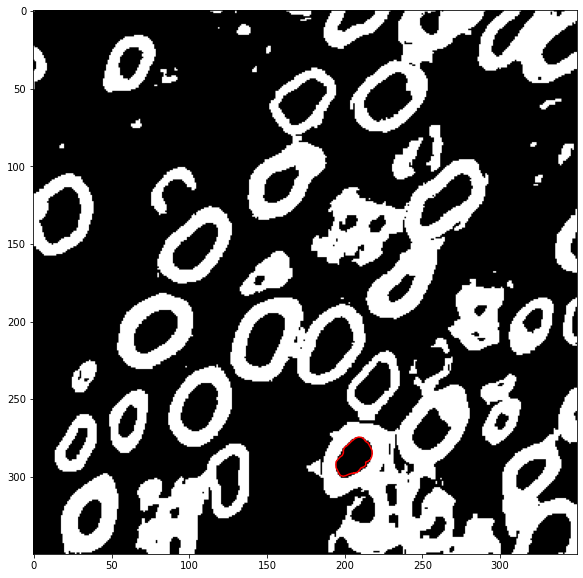

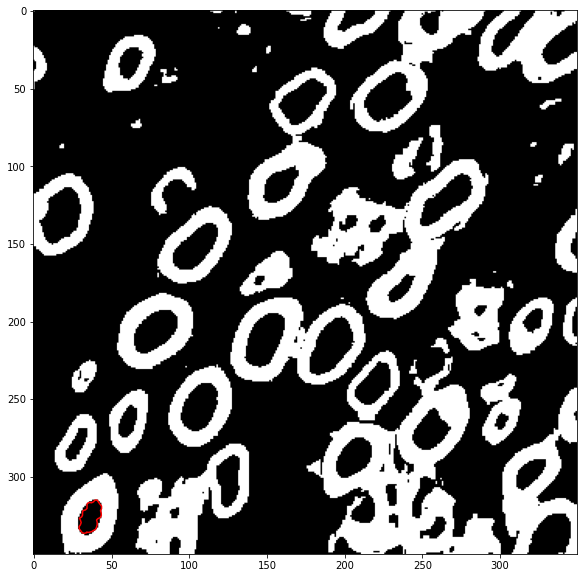

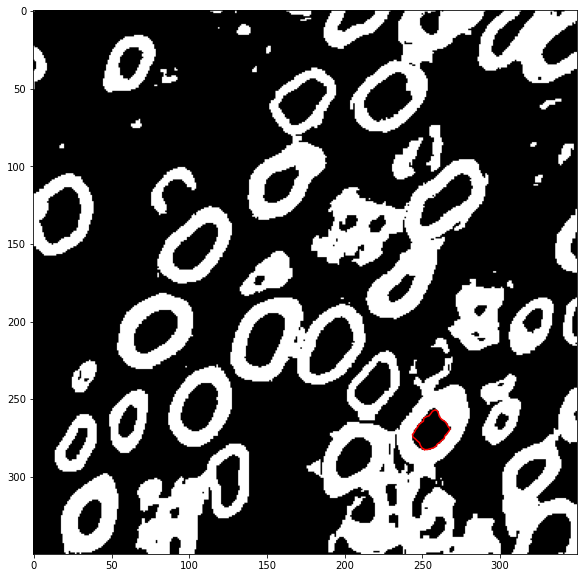

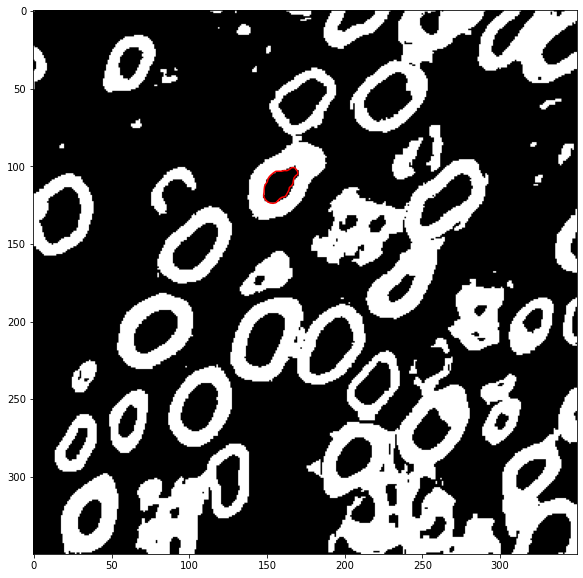

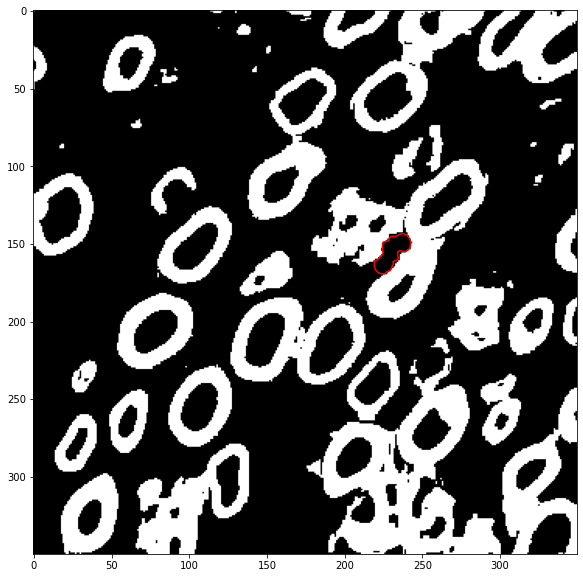

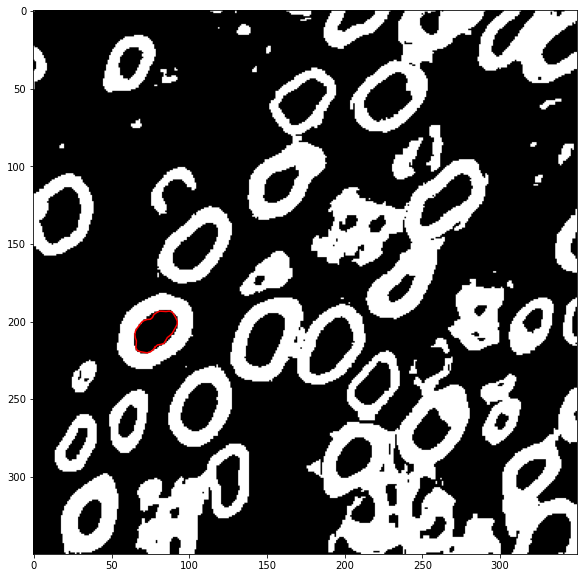

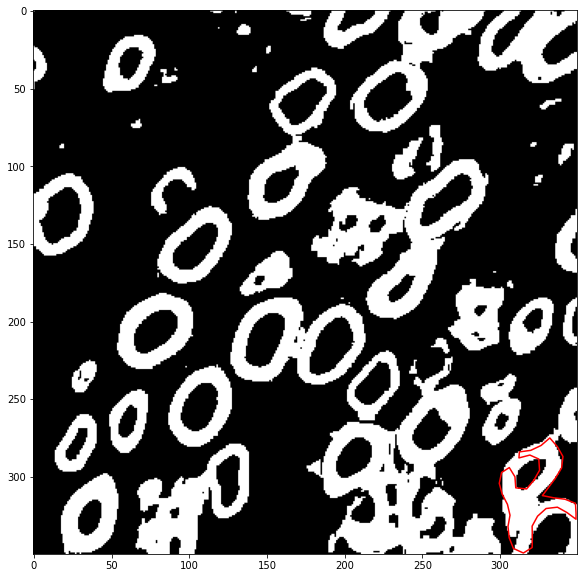

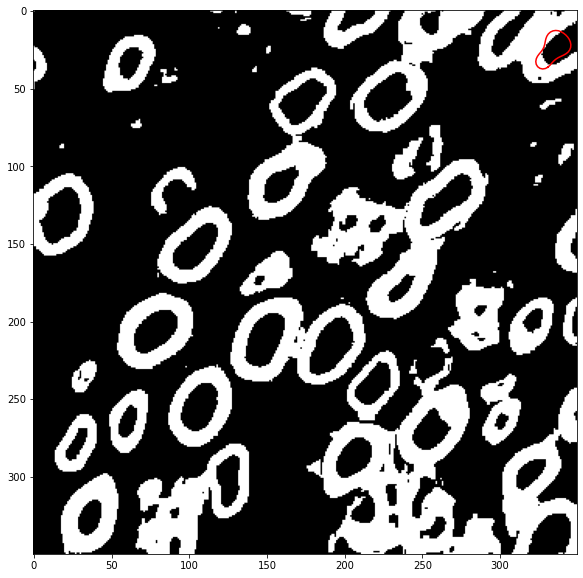

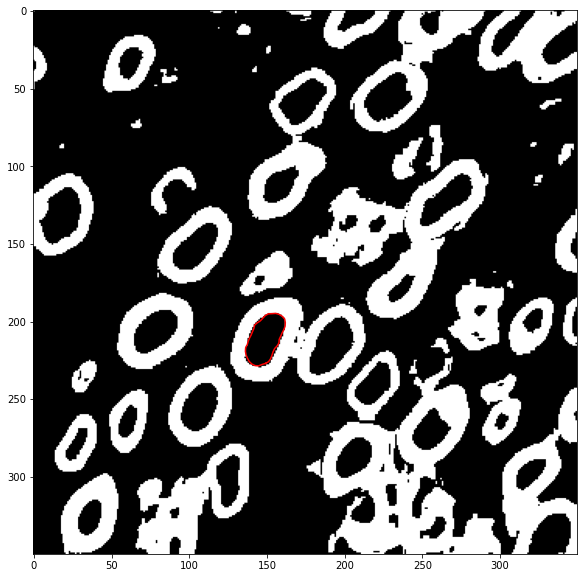

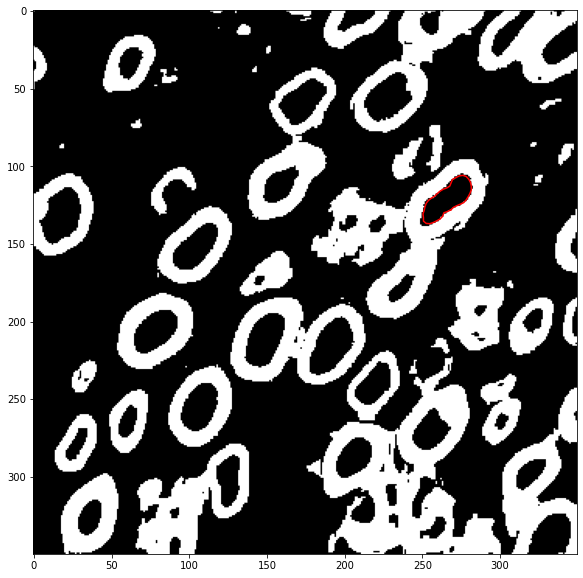

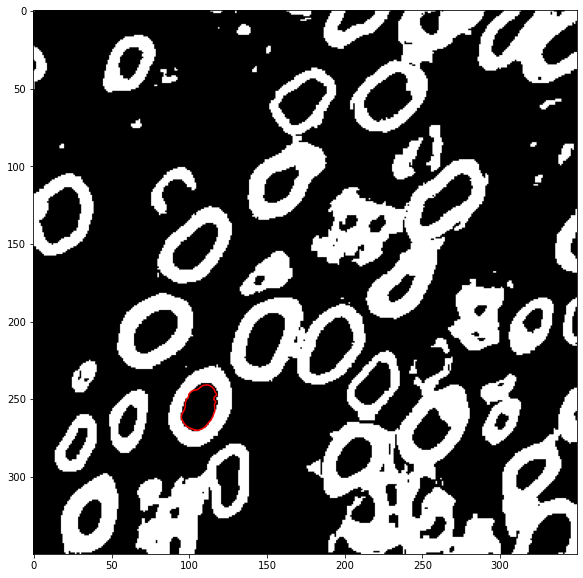

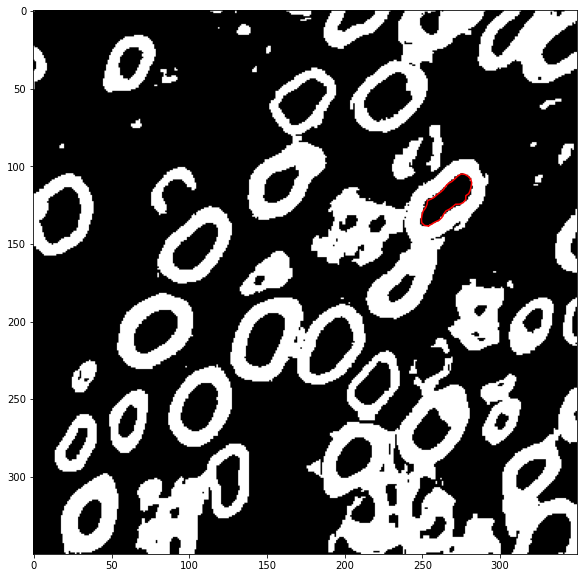

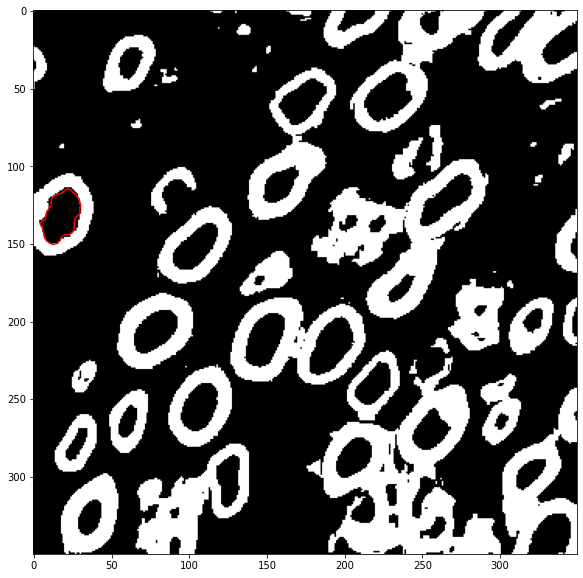

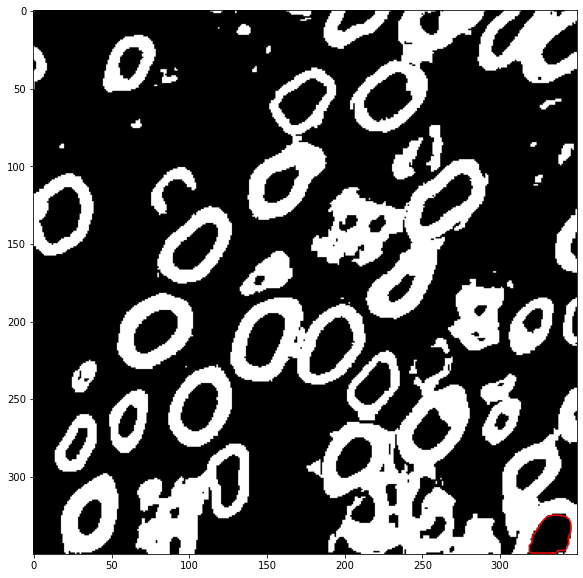

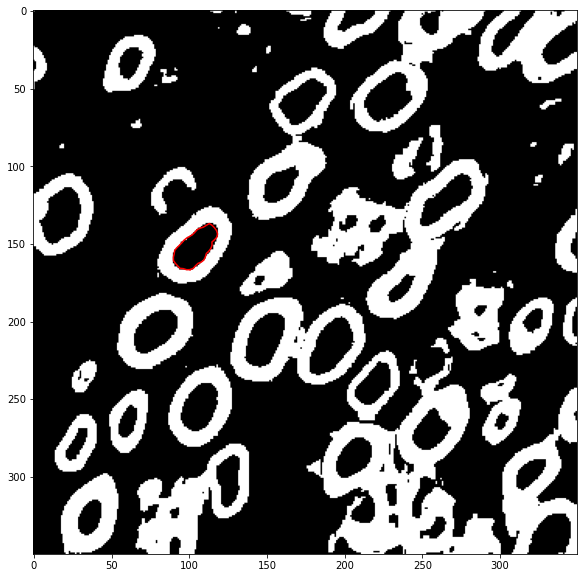

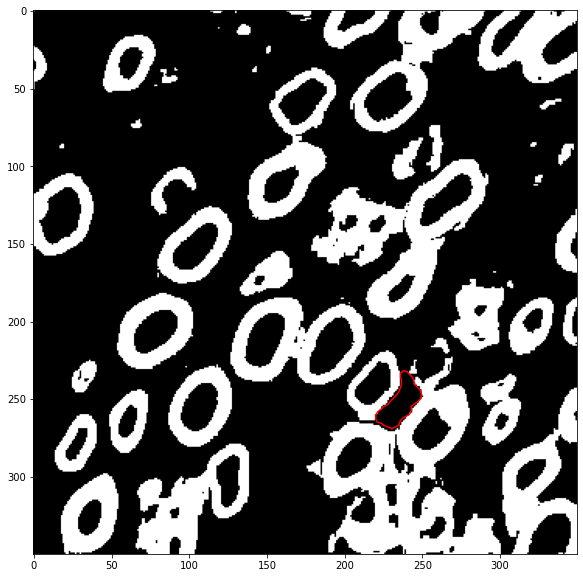

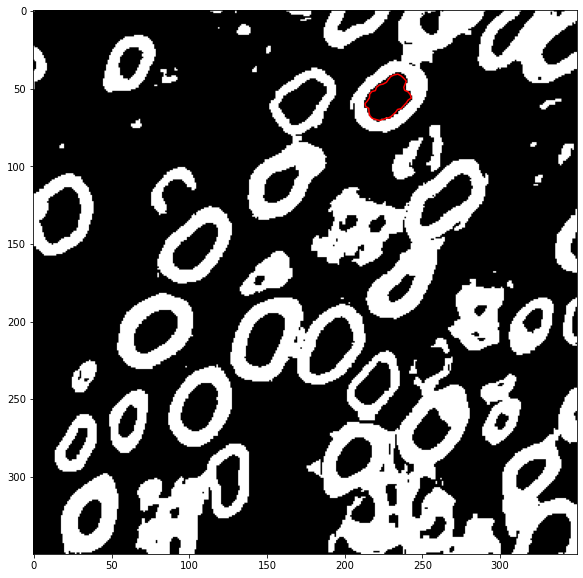

In [90]:
import simple_snake as sis
area=0
for j in range(0, coord_pos.shape[0]):
    m=coord_pos[j][0]
    n=coord_pos[j][1]

    nr_points = 40
    step_size = 4
    alpha = 0.1
    beta = 0.1
    center = np.array([m,n])
    radius = 3

    #%% initialization
    snake = sis.make_circular_snake(nr_points, center, radius)
    B = sis.regularization_matrix(nr_points, alpha, beta)
    frame = I_seg.astype(float)
    fig, ax = plt.subplots()
    

    for i in range(100):    
        snake = sis.evolve_snake(snake, frame, B, step_size) 
    area+=calculate_area(snake)/coord_pos.shape[0]
    ax.imshow(frame, cmap='gray')
    ax.plot(np.r_[snake[1],snake[1,0]],np.r_[snake[0],snake[0,0]],'r-')
    #     ax.clear()
    
#     ax.imshow(frame, cmap='gray')
#     ax.plot(np.r_[snake[1],snake[1,0]],np.r_[snake[0],snake[0,0]],'r-')
#     ax.set_title(f'initialization, iter {i}')
#     plt.show()
print('Average axon area: '+str(area))